In [63]:
from CO2xSWV import fetch_data_from_NEON_API
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np

In [25]:
sitecodes = ['BART', 'ABBY']
productcodes = ['DP1.00095.001', 'DP1.00094.001','DP1.00041.001']
daterange = ['2020-09', '2020-11']
fetch_data_from_NEON_API(sitecodes, productcodes, daterange=daterange)
#ug, go pack and use dask to speed this up

DP1.00041.001-BART-2020-09


100%|██████████| 190/190 [00:24<00:00,  7.66it/s]


DP1.00041.001-BART-2020-10


100%|██████████| 190/190 [00:24<00:00,  7.82it/s]


DP1.00041.001-BART-2020-11


100%|██████████| 190/190 [00:24<00:00,  7.84it/s] 


DP1.00041.001-ABBY-2020-09


100%|██████████| 190/190 [00:22<00:00,  8.40it/s] 


DP1.00041.001-ABBY-2020-10


100%|██████████| 190/190 [00:23<00:00,  8.12it/s] 


DP1.00041.001-ABBY-2020-11


100%|██████████| 190/190 [00:24<00:00,  7.89it/s]


In [51]:
data_path='/home/jovyan/NEON/CO2xSWV_data'
site = 'ABBY'
soil_CO2 = glob.glob(f'{data_path}/*{site}*SCO2C_1_minute*.csv')
soil_H2O = glob.glob(f'{data_path}/*{site}*SWS_1_minute*.csv')
soil_T   = glob.glob(f'{data_path}/*{site}*ST_1_minute*.csv')

In [52]:
# make a df with date, and files for that date
sc = set([f.split('.')[-4] for f in soil_CO2])
sw = set([f.split('.')[-4] for f in soil_H2O])
st = set([f.split('.')[-4] for f in soil_T])
dates = list(sc & sw & st)
dates.sort()
c = []
w = []
t = []
for date in dates:
    # each comprehension should return 1 filename
    c.append([f for f in soil_CO2 if date in f][0])
    w.append([f for f in soil_H2O if date in f][0])
    t.append([f for f in soil_T if date in f][0])
filedf = pd.DataFrame()
filedf['date']   = dates
filedf['CO2']    = c
filedf['H2O']    = w
filedf['T_soil'] = t

In [56]:
# %%
#for date in dates:
#   row = filedf.loc[filedf.date==date]
#   f = row['CO2'] 
f = c[0]
co2 = pd.read_csv(f, parse_dates=True, index_col='startDateTime')
# Fail and pass columns are redundent, we will use the fails
drops = [col for col in list(co2.columns) if 'Pass' in col]
co2.drop(drops, axis='columns', inplace=True)
# drop columns with bad quality flags
x = len(co2)
co2 = co2.loc[co2.finalQF == 0] 
#if (x - len(co2)) / x > 0.2: continue
print(f'dropped {100 * (x - len(co2)) / x}%')
# now drop quality metric columns
qm = [col for col in list(co2.columns) if 'QM' in col]
qm = qm + [col for col in list(co2.columns) if 'QF' in col] + ['endDateTime']
co2.drop(qm, axis='columns', inplace=True)
#this following step should not be needed, but just in case
co2.dropna(inplace=True)
co2.info()

dropped 6.12962962962963%
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40552 entries, 2020-09-01 00:38:00+00:00 to 2020-09-30 23:58:00+00:00
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   soilCO2concentrationMean       40552 non-null  float64
 1   soilCO2concentrationMinimum    40552 non-null  float64
 2   soilCO2concentrationMaximum    40552 non-null  float64
 3   soilCO2concentrationVariance   40552 non-null  float64
 4   soilCO2concentrationNumPts     40552 non-null  float64
 5   soilCO2concentrationExpUncert  40552 non-null  float64
 6   soilCO2concentrationStdErMean  40552 non-null  float64
dtypes: float64(7)
memory usage: 2.5 MB


In [57]:
#%%
#   f = row['H2O']
f = w[0]
h2o = pd.read_csv(f, parse_dates=True, index_col='startDateTime')
# Fail and pass columns are redundent, we will use the fails
drops = [col for col in list(h2o.columns) if 'Pass' in col]
h2o.drop(drops, axis='columns', inplace=True)
# drop columns with bad quality flags
x = len(h2o)
h2o = h2o.loc[(h2o.VSWCFinalQF == 0) & (h2o.VSICFinalQF == 0)]
#if (x - len(h2o)) / x > 0.2: continue
print(f'dropped {100 * (x - len(h2o)) / x}%\nbut note that we are using FinalQFSciRvw != 2 rather than using FinalQF == 0 as our loc criteria')
# now drop quality metric columns
qm = [col for col in list(h2o.columns) if 'QM' in col]
qm = qm + [col for col in list(h2o.columns) if 'QF' in col] + ['endDateTime']
h2o.drop(qm, axis='columns', inplace=True)
#this following step should not be needed, but just in case
h2o.dropna(inplace=True)
h2o.info()

dropped 74.47916666666667%
but note that we are using FinalQFSciRvw != 2 rather than using FinalQF == 0 as our loc criteria
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11025 entries, 2020-09-01 00:00:00+00:00 to 2020-09-19 01:05:00+00:00
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   VSWCMean       11025 non-null  float64
 1   VSWCMinimum    11025 non-null  float64
 2   VSWCMaximum    11025 non-null  float64
 3   VSWCVariance   11025 non-null  float64
 4   VSWCNumPts     11025 non-null  float64
 5   VSWCExpUncert  11025 non-null  float64
 6   VSWCStdErMean  11025 non-null  float64
 7   VSICMean       11025 non-null  float64
 8   VSICMinimum    11025 non-null  float64
 9   VSICMaximum    11025 non-null  float64
 10  VSICVariance   11025 non-null  float64
 11  VSICNumPts     11025 non-null  float64
 12  VSICExpUncert  11025 non-null  float64
 13  VSICStdErMean  11025 non-null  float64
dtypes: float64(

In [58]:
#   f = row['soil_T']
f = t[0]
soil_T = pd.read_csv(f, parse_dates=True, index_col='startDateTime')
# Fail and pass columns are redundent, we will use the fails
drops = [col for col in list(soil_T.columns) if 'Pass' in col]
soil_T.drop(drops, axis='columns', inplace=True)
# drop columns with bad quality flags
x = len(soil_T)
soil_T = soil_T.loc[soil_T.finalQF == 0]
#if (x - len(soil_T)) / x > 0.2: continue
print(f'dropped {100 * (x - len(soil_T)) / x}%\nbut note that we are using FinalQFSciRvw != 2 rather than using FinalQF == 0 as our loc criteria')
# now drop quality metric columns
qm = [col for col in list(soil_T.columns) if 'QM' in col]
qm = qm + [col for col in list(soil_T.columns) if 'QF' in col] + ['endDateTime']
soil_T.drop(qm, axis='columns', inplace=True)
#this following step should not be needed, but just in case
soil_T.dropna(inplace=True)
soil_T.info()

dropped 2.7777777777777777%
but note that we are using FinalQFSciRvw != 2 rather than using FinalQF == 0 as our loc criteria
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42000 entries, 2020-09-01 00:00:00+00:00 to 2020-09-30 23:59:00+00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   soilTempMean       42000 non-null  float64
 1   soilTempMinimum    42000 non-null  float64
 2   soilTempMaximum    42000 non-null  float64
 3   soilTempVariance   42000 non-null  float64
 4   soilTempNumPts     42000 non-null  float64
 5   soilTempExpUncert  42000 non-null  float64
 6   soilTempStdErMean  42000 non-null  float64
dtypes: float64(7)
memory usage: 2.6 MB


In [59]:
co2 = co2.merge(h2o, left_index=True, right_index=True)
co2 = co2.merge(soil_T, left_index=True, right_index=True)
dayCO2 = co2.soilCO2concentrationMean.resample('1D').mean().dropna()
hourH2O = co2.VSWCMean.resample('1h').mean().dropna()
hourT = co2.soilTempMean.resample('1h').mean().dropna()

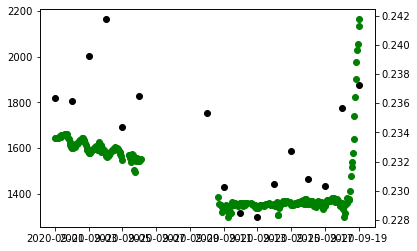

In [50]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(downsample.index, downsample, c='k')
ax2.scatter(hourH2O.index, hourH2O, c='g')

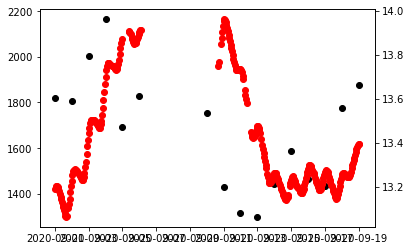

In [60]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(downsample.index, downsample, c='k')
ax2.scatter(hourT.index, hourT, c='r')

Text(0.5, 0, 'CO2 (ppm?)')

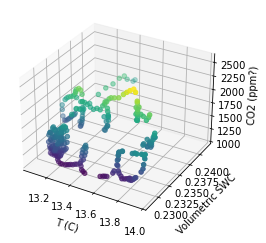

In [68]:
hourCO2 = co2.soilCO2concentrationMean.resample('1h').mean().dropna()
fig = plt.figure()
ax = plt.axes(projection='3d')

x = hourT
y = hourH2O
z = hourCO2

ax.scatter(x, y, z, c=z)

ax.set_xlabel('T (C)')
ax.set_ylabel('Volumetric SWC')
ax.set_zlabel('CO2 (ppm?)')